<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_0_Modelo_Univariante_ARIMA_RF__SPI_SPEI(Por_cluster).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalación de SKtime

In [2]:
%pip install sktime
%pip install sktime[all_extras]
%pip install esig
%pip install utils
%pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 18.2 MB/s 
     |████████████████████████████████| 9.8 MB 47.4 MB/s 
     |████████████████████████████████| 34.5 MB 13 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 4.3 MB/s 
     |████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 3.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)
simplefilter(action="ignore", category=FutureWarning)
# simplefilter(action="ignore", category=ModelFitWarning)

Importar librerías básicas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,\
                                                   mean_absolute_error, mean_squared_error

# AutoARIMA
from sktime.forecasting.arima import AutoARIMA

# Algoritmos de Regresión de sklearn
from sklearn.ensemble import RandomForestRegressor

In [3]:
t0 = pd.Timestamp.now()

In [4]:
#Definición de funciones

def evaluar_modelo(test,pred):
  print('MAPE:',mean_absolute_percentage_error(test, pred, symmetric=False)) 
  print('MAE:',mean_absolute_error(test, pred) )
  print('RMSE:',mean_squared_error(test, pred, square_root=True) ) # square_root=True RMSE , false MSE)
  print('MSE:',mean_squared_error(test, pred, square_root=False) ) # square_root=True RMSE , false MSE)

def graficar_modelo(train,test,pred,titulo='Modelo',inicio_serie=200,etiqy='Valor'):
  plot_series(train[inicio_serie:], test, pred, labels=["y_train", "y_test", "y_pred"])
  plt.axhline(y=0.5, color='r', linestyle='dashed')
  plt.title(titulo, c='darkblue', fontweight='bold', fontsize=15)
  plt.ylabel(etiqy.upper(), fontweight='bold', fontsize=12)
  plt.show()
  #plt.savefig('../datos/4.1.Resultados_Graficas/'+titulo.replace(' ','')+'_'+etiqy.split(' ')[0]+'.png', dpi=300)


def graficar_pred_est(data, modelo, clust=[0,1,2,3], escala=[3,12]):
  predic = data

  if 'spi' in predic.columns[0] : s = 'spi'
  else : s = 'spei'

  for e in escala:
    indice = [ind for ind in predic.columns if s+str(e) in ind]
    print('Escala: '+str(e))
    if not indice: 
      print(indice)
      continue
    else:
      datos = cargar_datos('indices_'+s+str(e)+'.csv')
      p_datos = procesa_datos(datos)
      datos_normalizados=normalizar_datos(p_datos)

      for c in clust:
        
        cad = s+str(e)+'_c'+str(c)
        
        if (cad not in predic.columns):
          continue
        else:
          estaciones = cluster[cluster['cluster'] == c].reset_index(drop=True)
          

          for est in range(estaciones.shape[0]):
            estacion = [col for col in datos_normalizados.columns if str(estaciones['id'][est]) in col]
            serie = datos_normalizados.loc[:,estacion]
            train, test = dividir_datos(serie, tamanio = tam_ypred)
            pred = data.iloc[:,0]
            pred.index = test.index
            nom_est = 'Estacion '+str(estaciones.iloc[est,0])+' - '+str(estaciones.iloc[est,1]).capitalize() 
            nom_clu = 'Cluster ' + str(c) + ' - '

            graficar_modelo(train, test, pred,titulo=modelo+' - '+nom_clu+nom_est, inicio_serie=0, etiqy = s+str(e)+' - Normalizado')

# 1. Cargar los datos de SPI

In [5]:
def cargar_datos(archivo):
    data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    return data

# 2. Preprocesamiento de los datos

In [6]:
'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

## Normalizar los datos

In [7]:
'''para mejores resultados se pueden normalizar los datos: [0,1]'''
def normalizar_datos(data):
    return (data - data.min()) / ( data.max() - data.min())

## Generar cluster

In [8]:
'''Devuelve un Dataframe con todas las estaciones de un determinado cluster'''
def gen_cluster(lista_clust, clust, normalizados):
    estaciones = lista_clust[lista_clust['cluster'] == clust]
    nom_cols = [col for est in estaciones['id'] for col in normalizados.columns if str(est) in col]
    datos = normalizados[nom_cols]
    datos = datos.melt(value_name='valor').reset_index(drop=True)
    return datos.iloc[:, 1]

# 3. Dividir Datos en Entrenamiento y prueba

In [9]:
'''Dividir el Dataset en Entrenamiento y prueba'''
def dividir_datos(serie, tamanio):
    y_train, y_test = temporal_train_test_split(serie, test_size=tamanio)
    return y_train, y_test

## Definir  el horizonte de predicción

In [10]:
'''Definir horizonte de predicción'''
def horizon_prediccion(y_test):
    return ForecastingHorizon(y_test.index, is_relative=False)  

# 4. Configuración del algoritmo

In [11]:
def config_algoritmo(algoritmo, estacionalidad = 12, ventana = 12, estrategia = 'mean'):
    return AutoARIMA(sp=estacionalidad, suppress_warnings=True) #Cambiar sp para reducir el error

def config_algoritmoReg(algoritmo,ventana = 12, estrategia = 'recursive',estimadores=30, vecinos=11):
  reg=RandomForestRegressor(n_estimators=estimadores)
  return make_reduction(reg,strategy=estrategia, window_length=ventana)

# 5. Ajuste del Modelo

In [12]:
def ajuste(predictor, y_train):
    return predictor.fit(y_train)

# 6. Predicción del Modelo

In [13]:
def prediccion(predictor, horiz_prediccion):
    return predictor.predict(horiz_prediccion)

# 7. Evaluación del Modelo

In [14]:
def evaluacion_modelo(test,pred):
    mape = mean_absolute_percentage_error(test, pred, symmetric=False)
    mae = mean_absolute_error(test, pred) 
    rmse = mean_squared_error(test, pred, square_root=True) # square_root=True RMSE , false MSE)
    mse = mean_squared_error(test, pred, square_root=False) # square_root=True RMSE , false MSE)
    return [mape, mae, rmse, mse]

# MODELOS ESTADÍSTICOS DE FORECASTING (SERIES TEMPORALES)

## Definir horizonte de predicción e índice

In [15]:
tam_ypred = 12
indice='spi'

# **ARIMA PARA SPI3**

In [16]:
'''cargar archivos con datos de cluster'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster', 'estacion'})

'''-- Declara DF para almacenar los y_pred,
      DF para almacenar los datos de la evaluacion'''
df_predts = pd.DataFrame()
df_evalts = pd.DataFrame(index = ['MAPE','MAE','RMSE','MSE'])
columnas = []


'''Escala representa la escala temporal de SPI y SPEI = 3,12'''
for escala in [3]:
        
    '''1. Cargar archivo SPI-SPEI'''
    cad = indice+str(escala)
    datos = cargar_datos('indices_' +cad+ '.csv')

    '''2. Procesamiento de datos'''
    datos_procesados = procesa_datos(datos)

    '''-- Normalizar datos'''
    datos_normalizados = normalizar_datos(datos_procesados)
    
    '''definir los clusters'''
    lista_cluster = sorted(cluster['cluster'].unique())
    
    '''i representa el número de cluster'''
    for i in  lista_cluster:
        print(f'escala {escala} - cluster {i}')
        '''-- Trabajar con un cluster'''
        serie = gen_cluster(cluster, i, datos_normalizados)

        '''3. Datos de entrenamiento y prueba'''
        y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)

        '''Definir el horizonte de predicción'''
        horizonte_prediccion = horizon_prediccion(y_test)

        '''4. Configurar algoritmo '''
        predictor = config_algoritmo('arima', estacionalidad = 12, ventana = 48, estrategia = 'mean')

        '''5. Ajuste modelo'''
        predictor = ajuste(predictor, y_train)

        '''6. Predicción'''
        y_pred = prediccion(predictor, horizonte_prediccion)

        '''7. Evaluación'''
        datos_eval = evaluacion_modelo(y_test, y_pred)

        '''-- Almacenar todos los y_pred, datos_eval en DFs y nombre de columnas'''
        df_predts = pd.concat([df_predts, y_pred.reset_index(drop=True)], axis = 1)
        df_evalts[indice+str(escala)+'_c'+str(i)] = datos_eval
        columnas.append(indice+str(escala)+'_c'+str(i))

'''Cambiar el nombre de las columnas'''
df_predts.columns = columnas

escala 3 - cluster 0
escala 3 - cluster 1
escala 3 - cluster 2
escala 3 - cluster 3


In [17]:
df_spi3_predts=df_predts
df_spi3_predts

spi3_c0   spi3_c1   spi3_c2   spi3_c3
0   0.419597  0.520404  0.357035  0.521670
1   0.438124  0.445070  0.388292  0.515364
2   0.482345  0.468089  0.469761  0.534763
3   0.503097  0.471661  0.489674  0.540641
4   0.516172  0.467196  0.473489  0.541996
5   0.519354  0.492441  0.496389  0.558949
6   0.519320  0.466763  0.483839  0.561029
7   0.517702  0.477365  0.492054  0.547563
8   0.516274  0.458320  0.489259  0.531905
9   0.515289  0.458995  0.491370  0.551151
10  0.514805  0.464397  0.489035  0.541187
11  0.514624  0.464724  0.482208  0.559114

In [18]:
df_spi3_evalts=df_evalts
df_spi3_evalts

spi3_c0   spi3_c1   spi3_c2   spi3_c3
MAPE  0.131113  0.190571  0.443578  0.125482
MAE   0.049674  0.073091  0.128463  0.058102
RMSE  0.072303  0.090058  0.151306  0.071925
MSE   0.005228  0.008110  0.022894  0.005173

Escala: 3


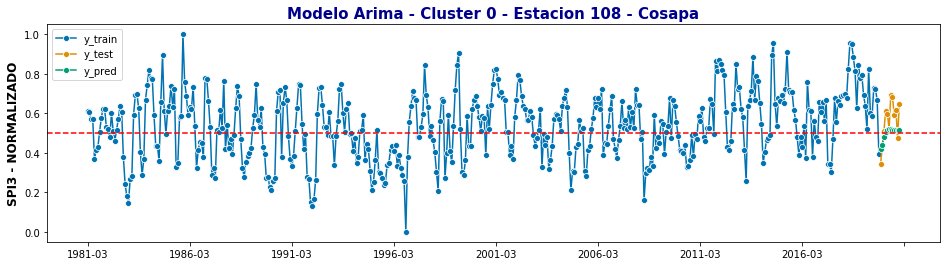

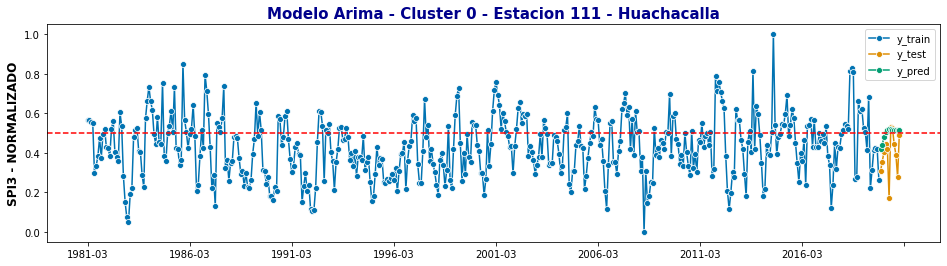

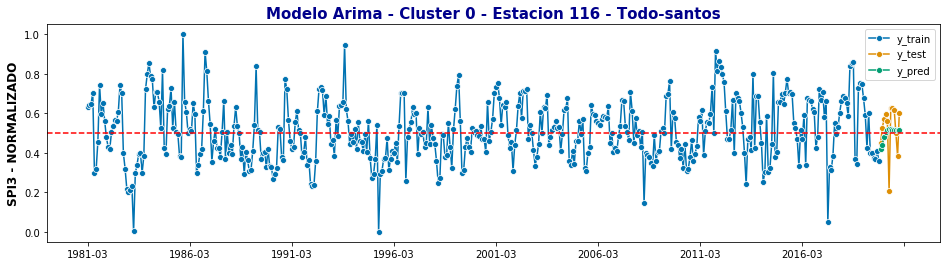

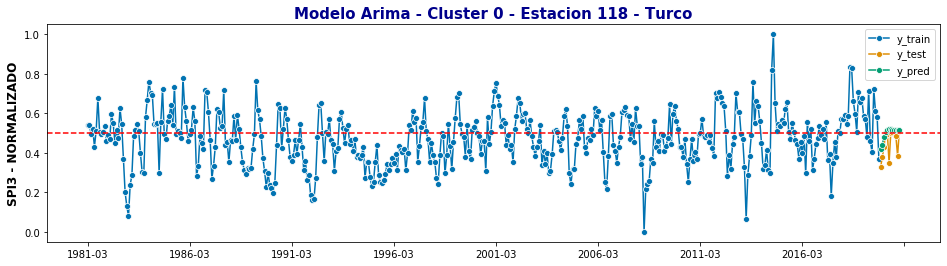

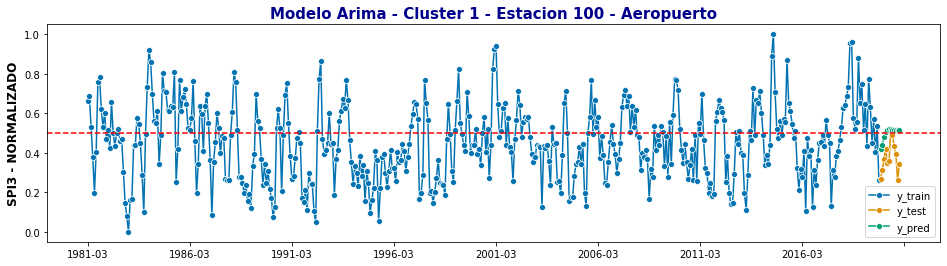

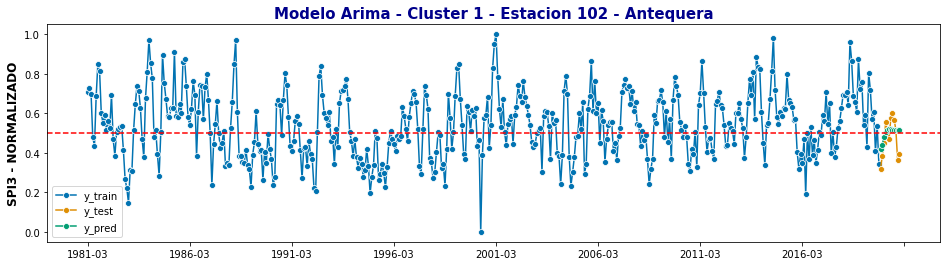

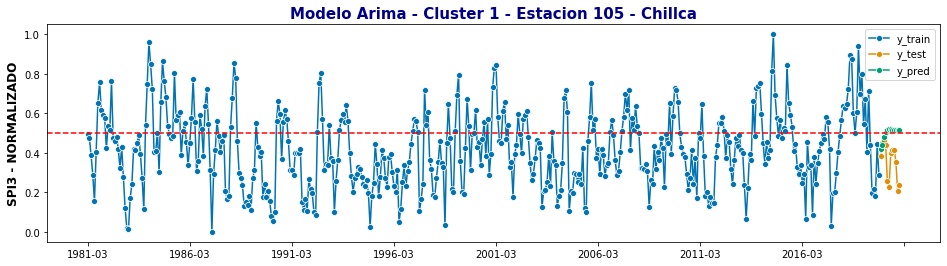

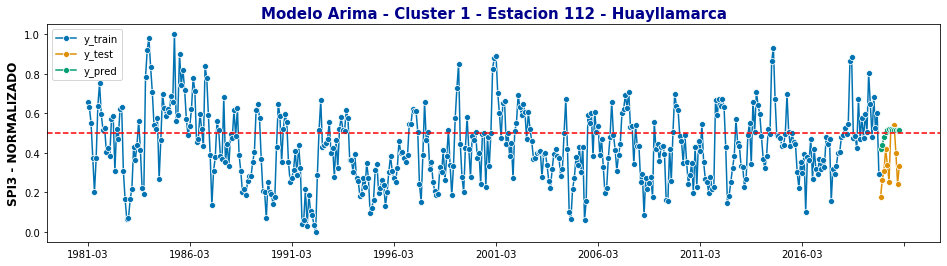

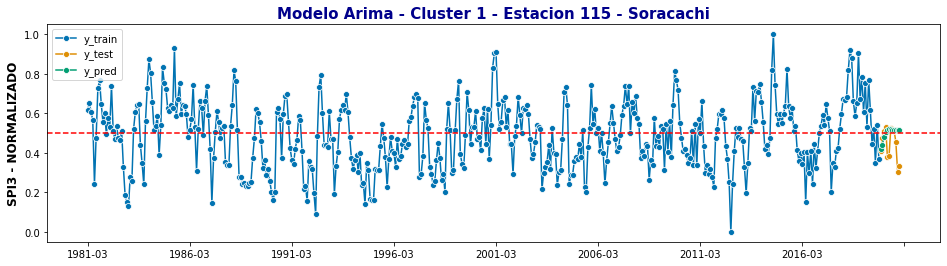

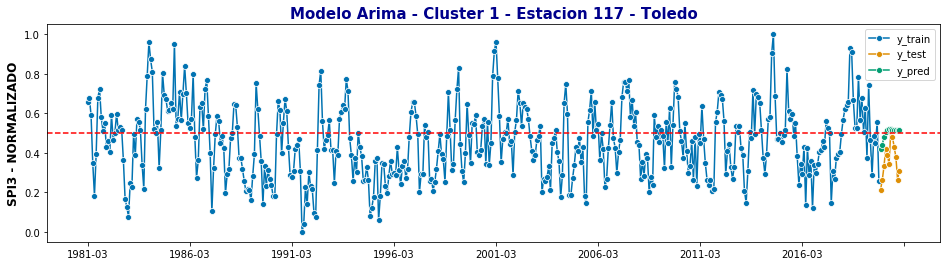

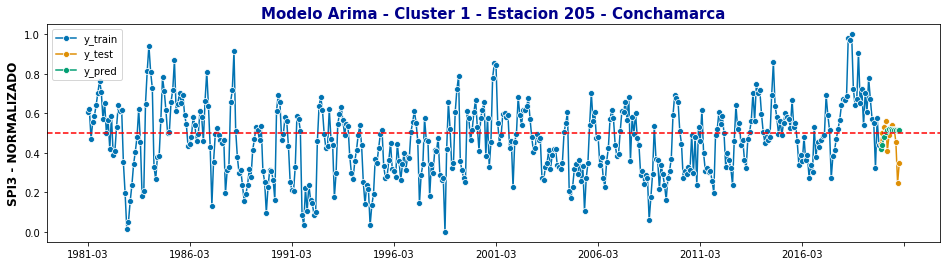

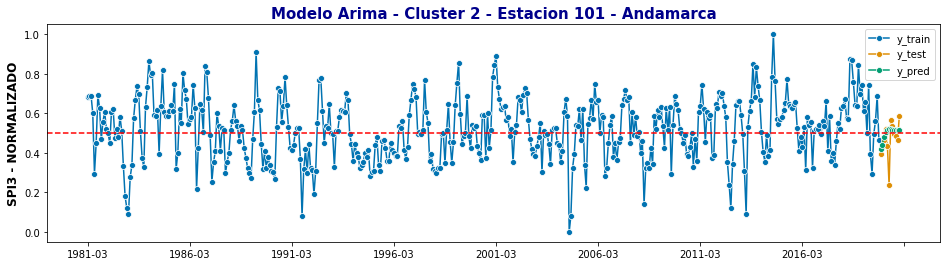

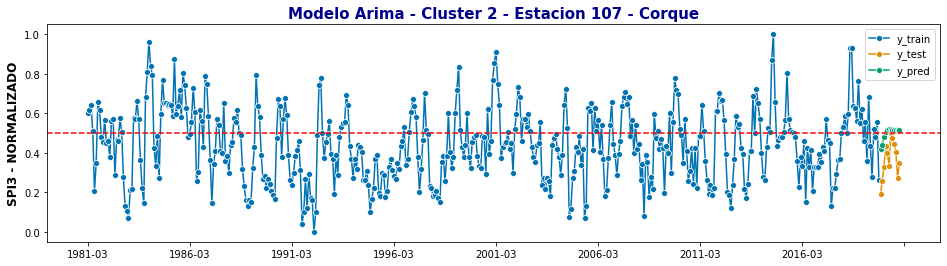

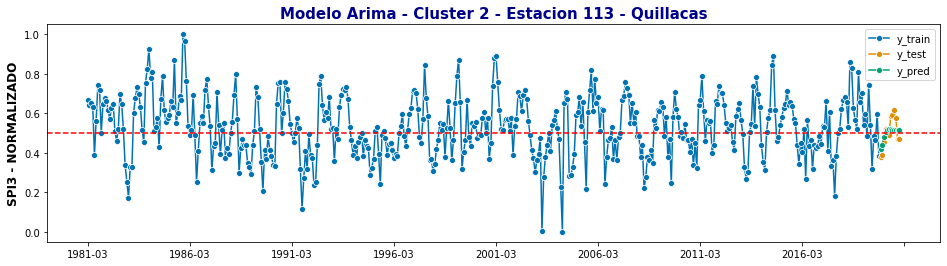

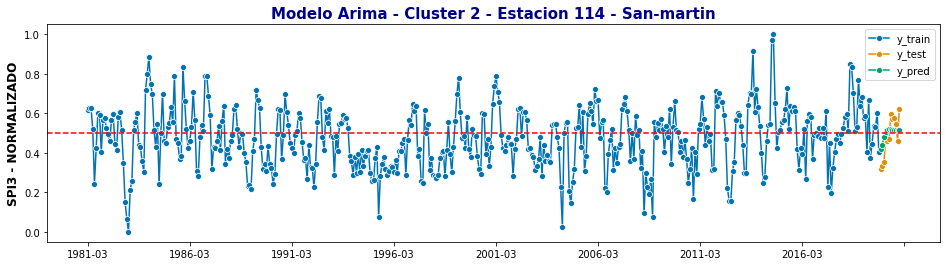

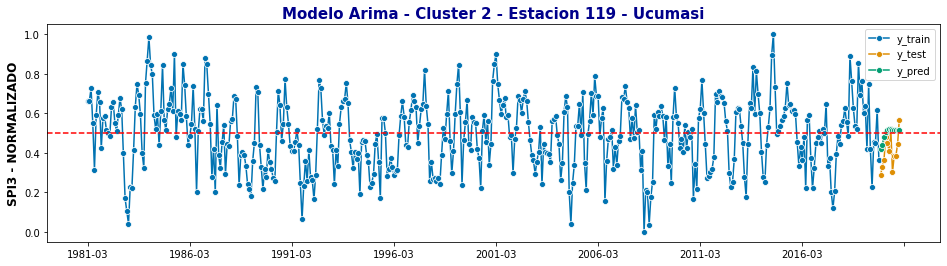

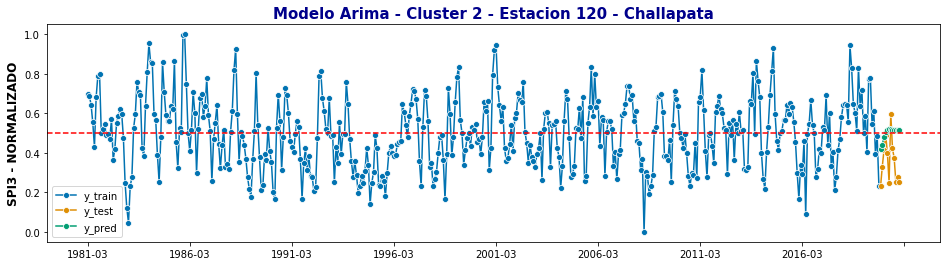

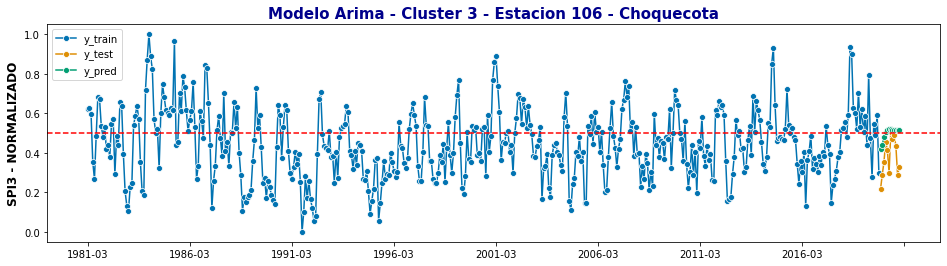

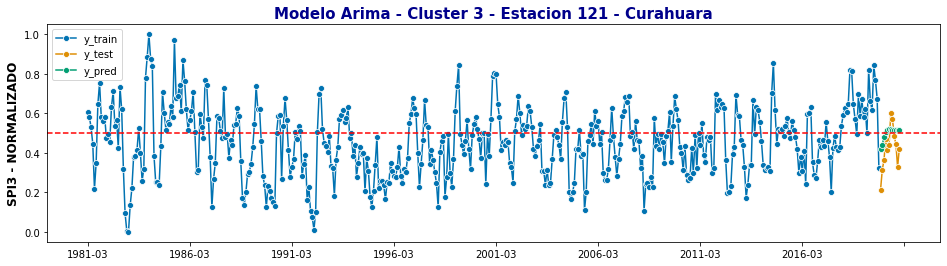

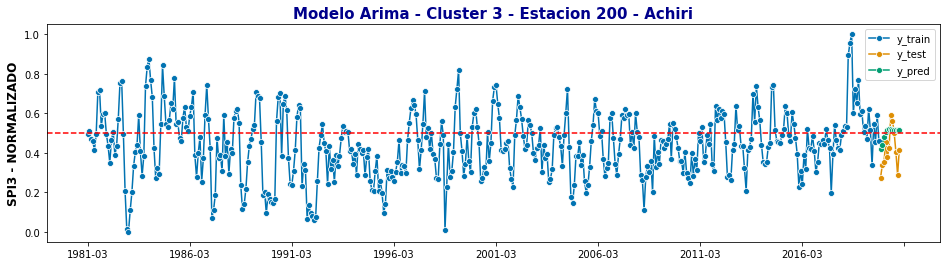

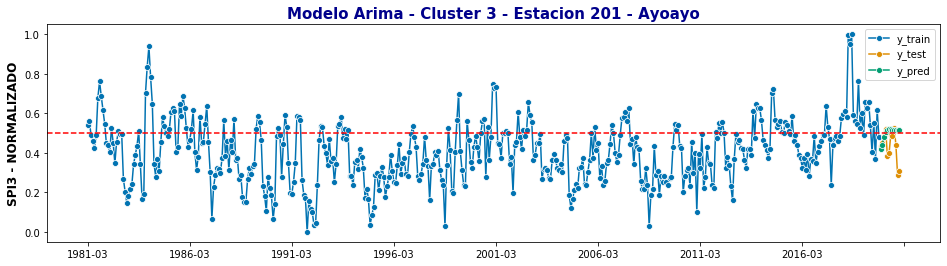

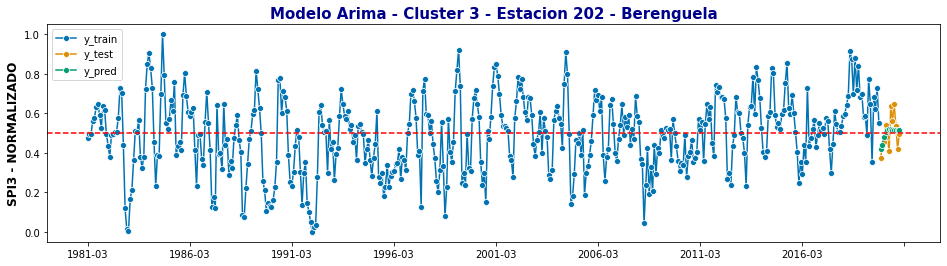

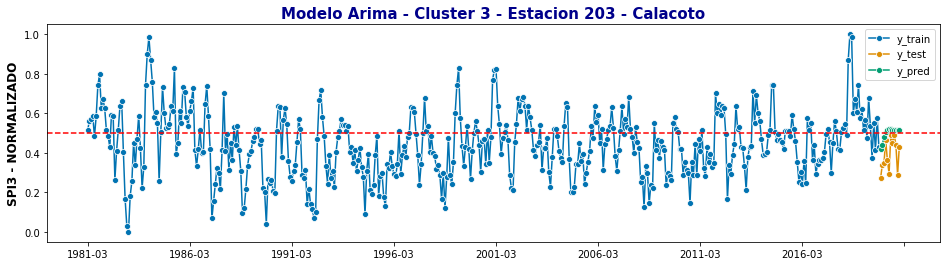

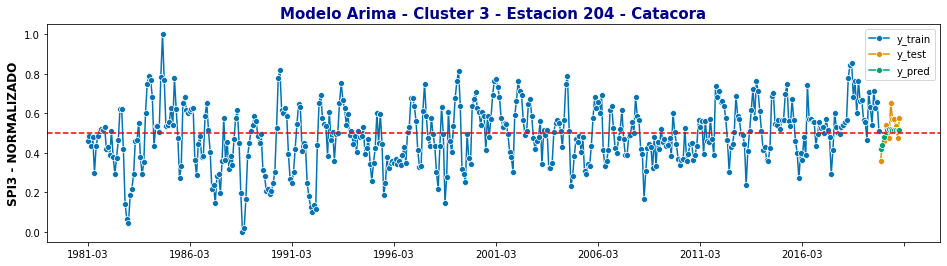

Escala: 12
[]


In [19]:
graficar_pred_est(df_spi3_predts, 'Modelo Arima')

# **ARIMA PARA SPI12**

In [20]:
'''cargar archivos con datos de cluster'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster', 'estacion'})

'''-- Declara DF para almacenar los y_pred,
      DF para almacenar los datos de la evaluacion'''
df_predts = pd.DataFrame()
df_evalts = pd.DataFrame(index = ['MAPE','MAE','RMSE','MSE'])
columnas = []


'''Escala representa la escala temporal de SPI y SPEI = 3,12'''
for escala in [12]:
        
    '''1. Cargar archivo SPI-SPEI'''
    cad = indice+str(escala)
    datos = cargar_datos('indices_' +cad+ '.csv')

    '''2. Procesamiento de datos'''
    datos_procesados = procesa_datos(datos)

    '''-- Normalizar datos'''
    datos_normalizados = normalizar_datos(datos_procesados)
    
    '''definir los clusters'''
    lista_cluster = sorted(cluster['cluster'].unique())
    
    '''i representa el número de cluster'''
    for i in  lista_cluster:
        print(f'escala {escala} - cluster {i}')
        '''-- Trabajar con un cluster'''
        serie = gen_cluster(cluster, i, datos_normalizados)

        '''3. Datos de entrenamiento y prueba'''
        y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)

        '''Definir el horizonte de predicción'''
        horizonte_prediccion = horizon_prediccion(y_test)

        '''4. Configurar algoritmo '''
        predictor = config_algoritmo('arima', estacionalidad = 12, ventana = 48, estrategia = 'mean')

        '''5. Ajuste modelo'''
        predictor = ajuste(predictor, y_train)

        '''6. Predicción'''
        y_pred = prediccion(predictor, horizonte_prediccion)

        '''7. Evaluación'''
        datos_eval = evaluacion_modelo(y_test, y_pred)

        '''-- Almacenar todos los y_pred, datos_eval en DFs y nombre de columnas'''
        df_predts = pd.concat([df_predts, y_pred.reset_index(drop=True)], axis = 1)
        df_evalts[indice+str(escala)+'_c'+str(i)] = datos_eval
        columnas.append(indice+str(escala)+'_c'+str(i))

'''Cambiar el nombre de las columnas'''
df_predts.columns = columnas

escala 12 - cluster 0
escala 12 - cluster 1
escala 12 - cluster 2
escala 12 - cluster 3


In [21]:
df_spi12_predts=df_predts
df_spi12_predts

spi12_c0  spi12_c1  spi12_c2  spi12_c3
0   0.684440  0.601525  0.425432  0.649102
1   0.604200  0.502180  0.305231  0.589219
2   0.639107  0.521211  0.403357  0.637138
3   0.625168  0.490320  0.377729  0.633522
4   0.625147  0.484045  0.379032  0.632082
5   0.624711  0.466343  0.370783  0.633038
6   0.628218  0.466694  0.369155  0.632706
7   0.628785  0.477481  0.370336  0.632920
8   0.618892  0.461566  0.355434  0.629835
9   0.628042  0.467126  0.362470  0.635756
10  0.626187  0.456691  0.358659  0.622585
11  0.683989  0.507169  0.458309  0.648478

In [22]:
df_spi12_evalts=df_evalts
df_spi12_evalts

spi12_c0  spi12_c1  spi12_c2  spi12_c3
MAPE  0.335938  0.075165  0.603194  0.157182
MAE   0.158547  0.039595  0.135950  0.085594
RMSE  0.159312  0.045052  0.143084  0.086268
MSE   0.025380  0.002030  0.020473  0.007442

Escala: 3
[]
Escala: 12


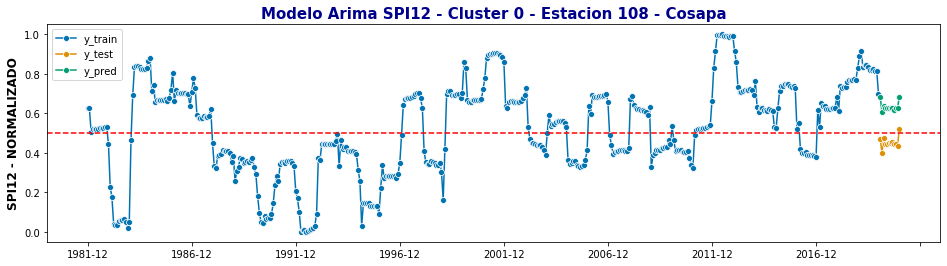

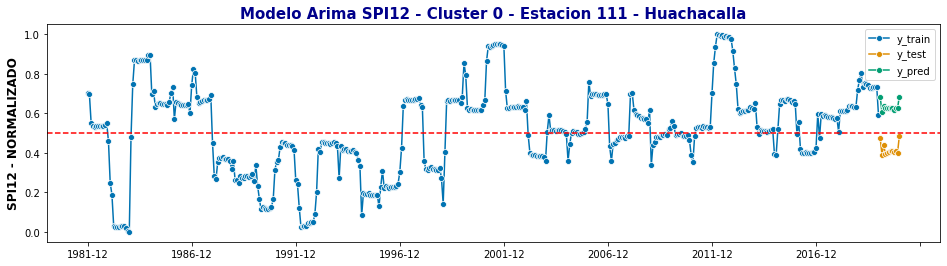

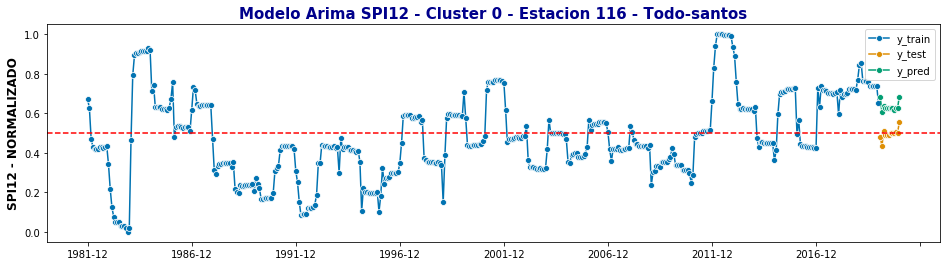

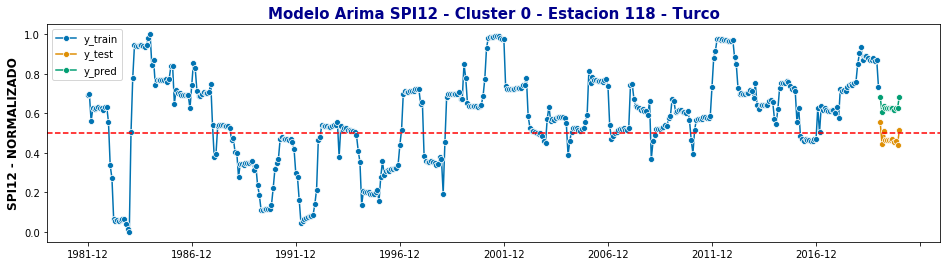

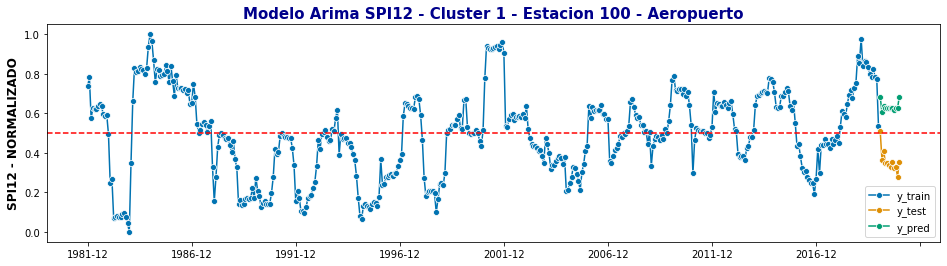

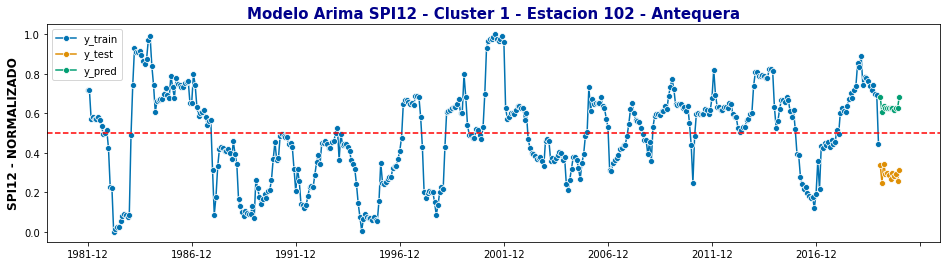

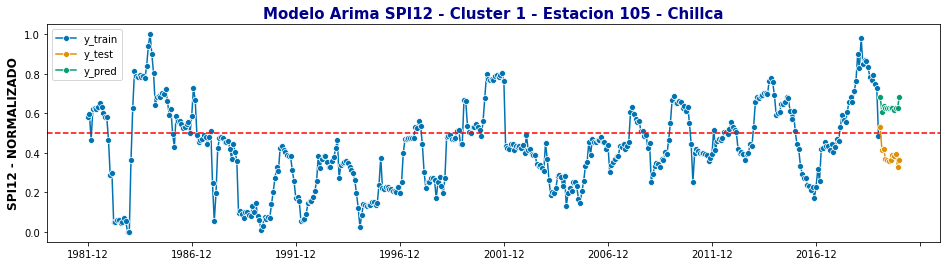

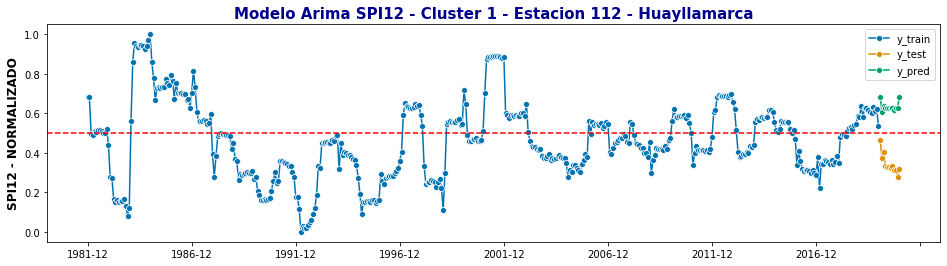

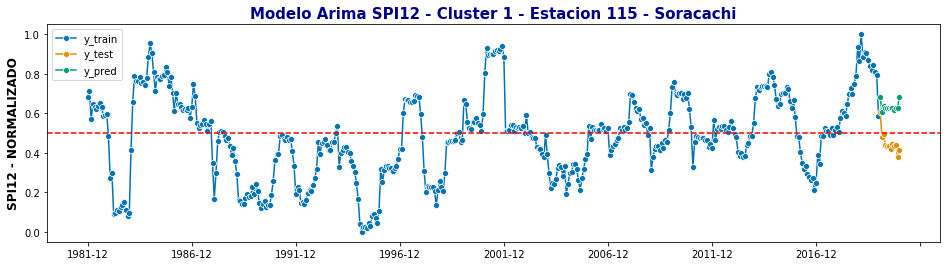

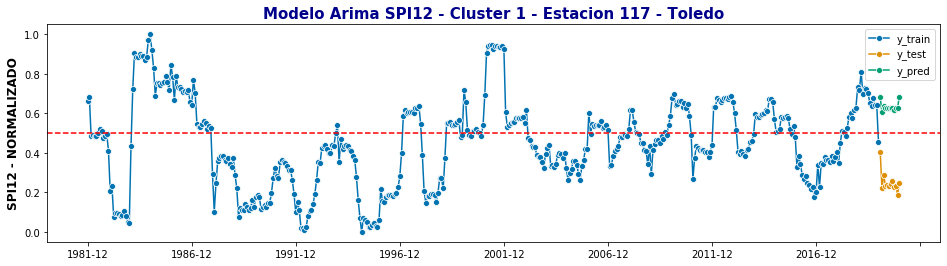

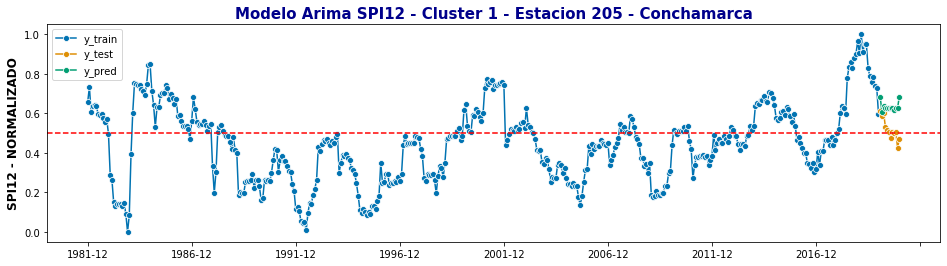

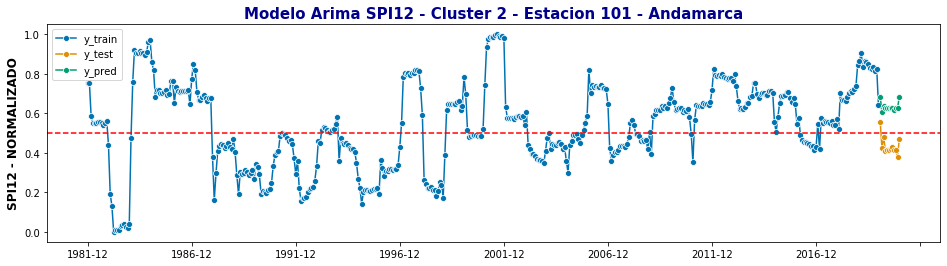

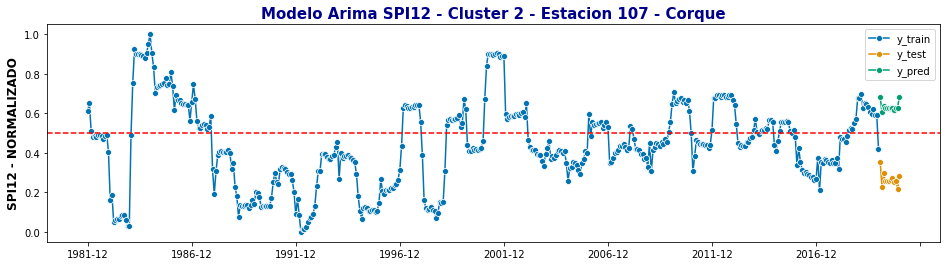

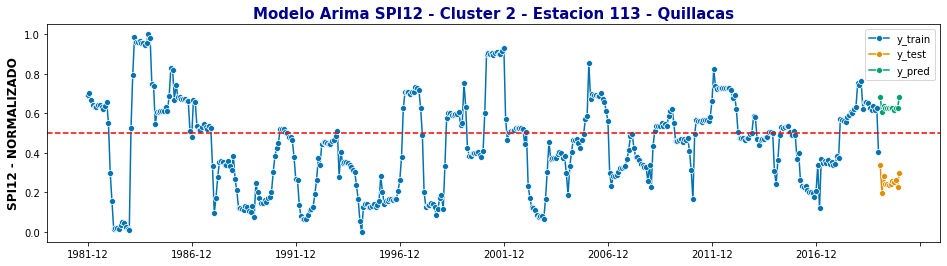

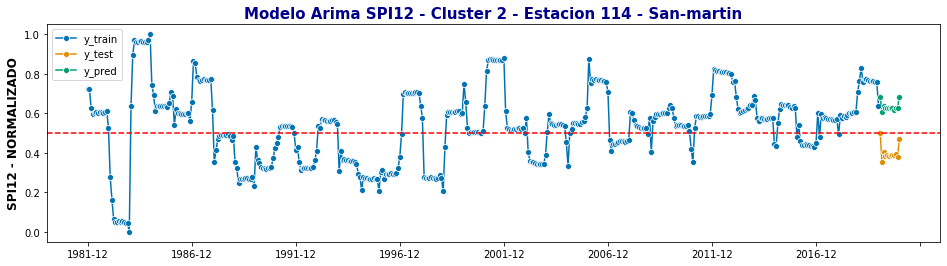

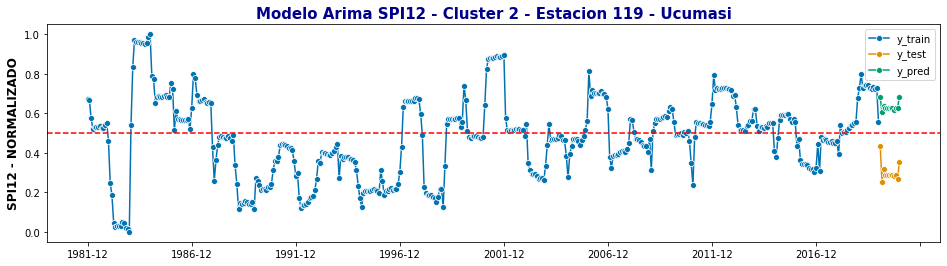

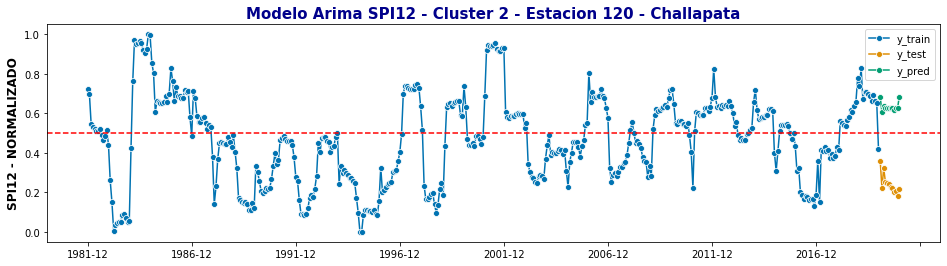

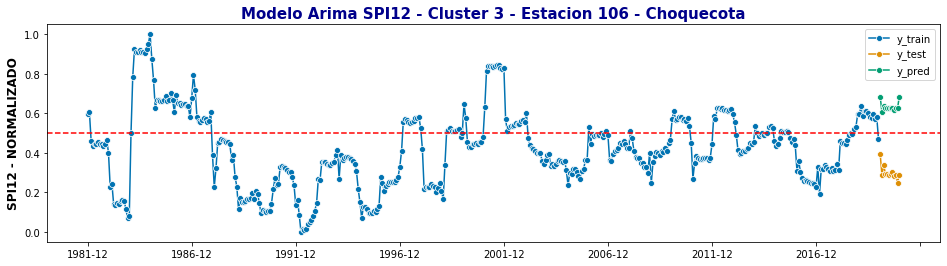

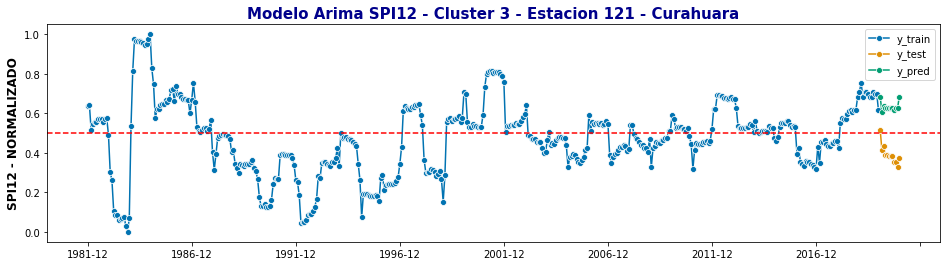

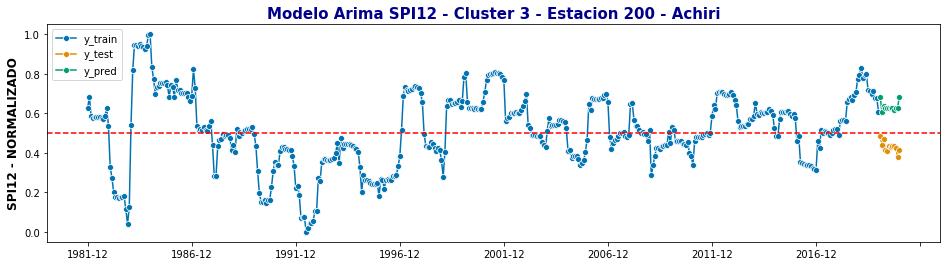

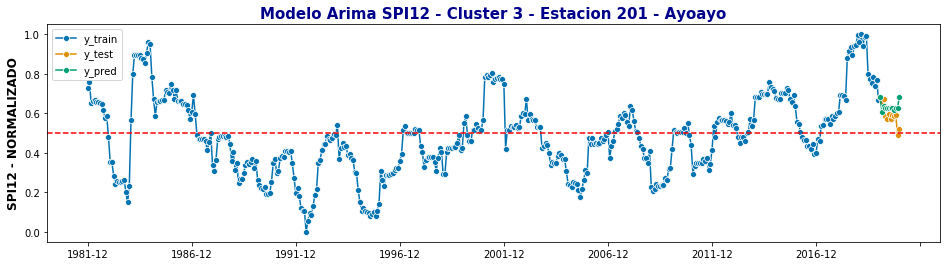

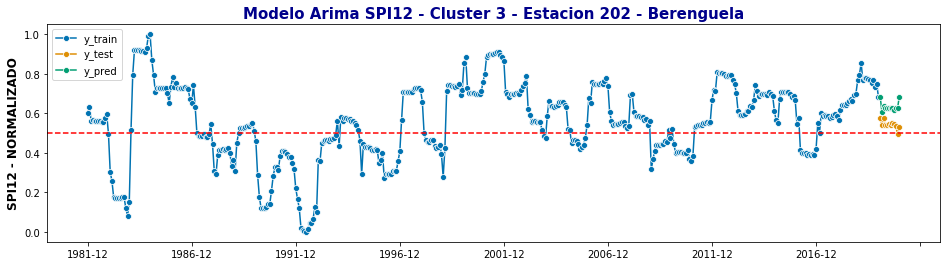

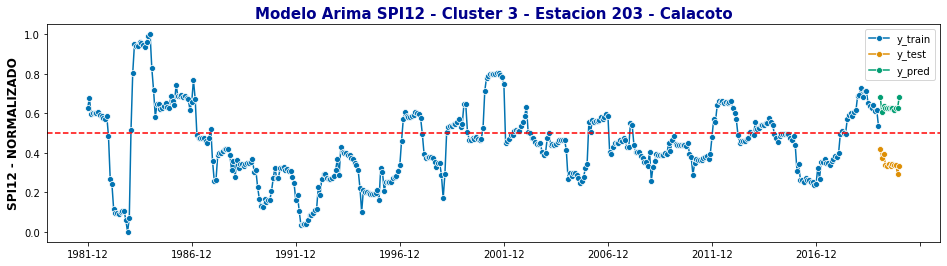

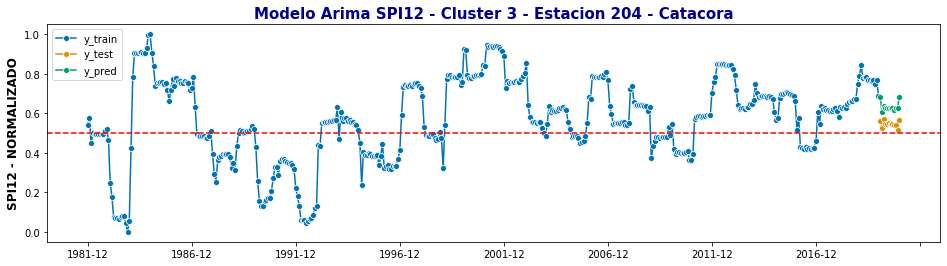

In [23]:
graficar_pred_est(df_spi12_predts, 'Modelo Arima SPI12')

# ALGORITMOS DE REGRESIÓN DE APRENDIZAJE AUTOMÁTICO

In [24]:
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_4.csv',  sep = ',', usecols = {'id', 'cluster', 'estacion'})

'''-- Declara DF para almacenar los y_pred,
      DF para almacenar los datos de la evaluacion'''
df_pred = pd.DataFrame()
df_eval = pd.DataFrame(index = ['MAPE','MAE','RMSE','MSE'])
columnas = []

'''Definir el horizonte de la prediccion'''
tam_ypred = 12

for escala in [3,12]:
        
    '''1. Cargar archivo'''
    cad = 'spi'+str(escala)
    datos = cargar_datos('indices_' +cad+ '.csv')

    '''2. Procesamiento de datos'''
    datos_procesados = procesa_datos(datos)

    '''-- Normalizar datos'''
    datos_normalizados = normalizar_datos(datos_procesados)    
    
    '''definir los clusters'''
    lista_cluster = sorted(cluster['cluster'].unique())
    for i in lista_cluster:
        print(f'escala {escala} - cluster {i}')
        '''-- Trabajar con un cluster'''
        serie = gen_cluster(cluster, i, datos_normalizados)

        '''3. Datos de entrenamiento y prueba'''
        y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)

        '''Definir el horizonte de predicción'''
        horizonte_prediccion = horizon_prediccion(y_test)

        '''4. Configurar algoritmo de regresión'''
        predictor = config_algoritmoReg('RandomForestRegressor',  ventana = 48, estrategia = 'recursive',estimadores=30, vecinos=11)

        '''5. Ajuste modelo'''
        predictor = ajuste(predictor, y_train)

        '''6. Predicción'''
        y_pred = prediccion(predictor, horizonte_prediccion)

        '''7. Evaluación'''
        datos_eval = evaluacion_modelo(y_test, y_pred)

        '''-- Almacenar todos los y_pred, datos_eval en DFs y nombre de columnas'''
        df_pred = pd.concat([df_pred, y_pred.reset_index(drop=True)], axis = 1)
        df_eval[indice+str(escala)+'_c'+str(i)] = datos_eval
        columnas.append(indice+str(escala)+'_c'+str(i))
        
'''Cambiar el nombre de las columnas'''
df_pred.columns = columnas



escala 3 - cluster 0
escala 3 - cluster 1
escala 3 - cluster 2
escala 3 - cluster 3
escala 12 - cluster 0
escala 12 - cluster 1
escala 12 - cluster 2
escala 12 - cluster 3


Escala: 3


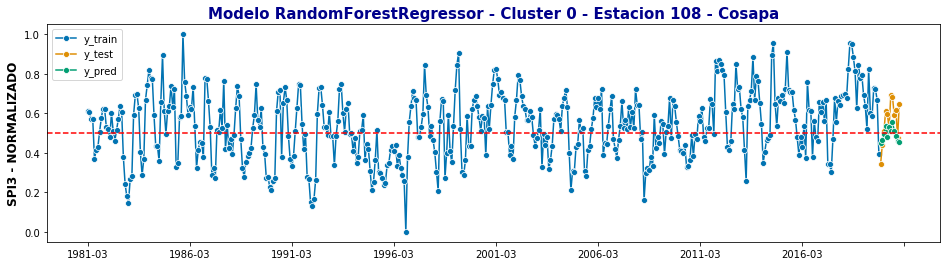

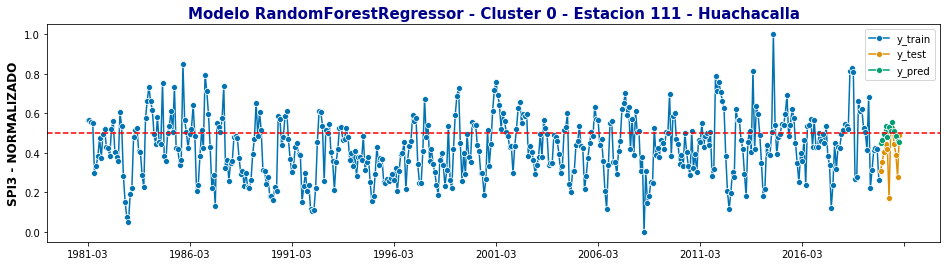

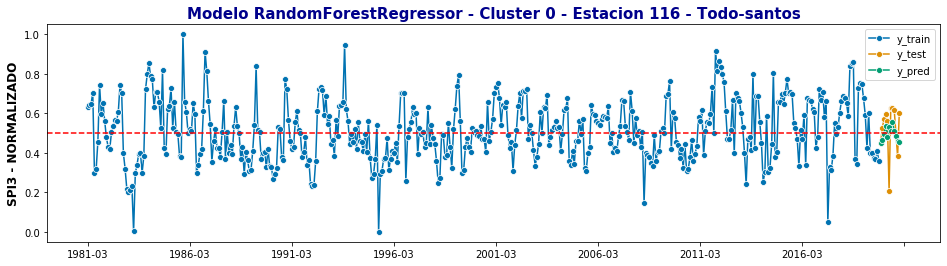

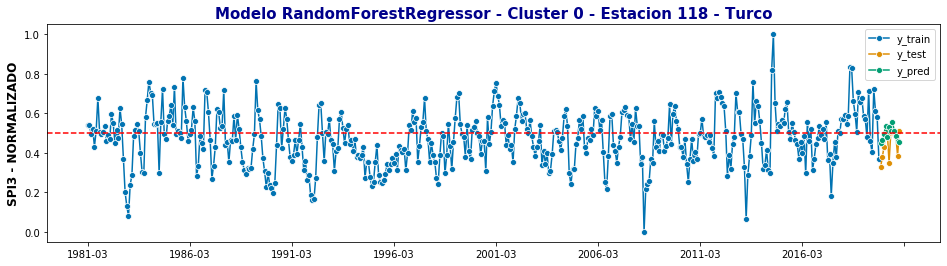

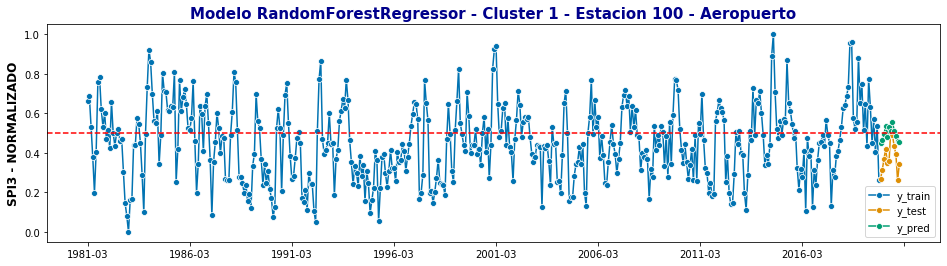

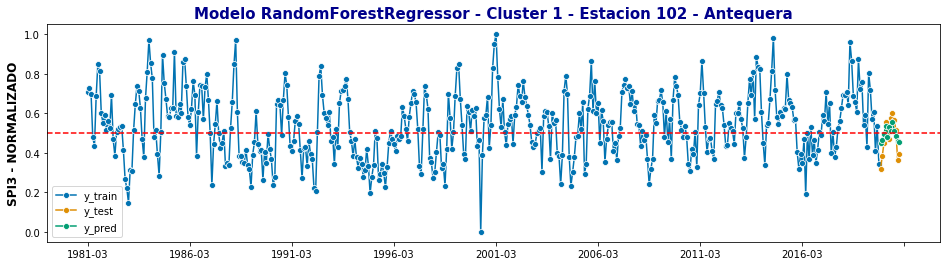

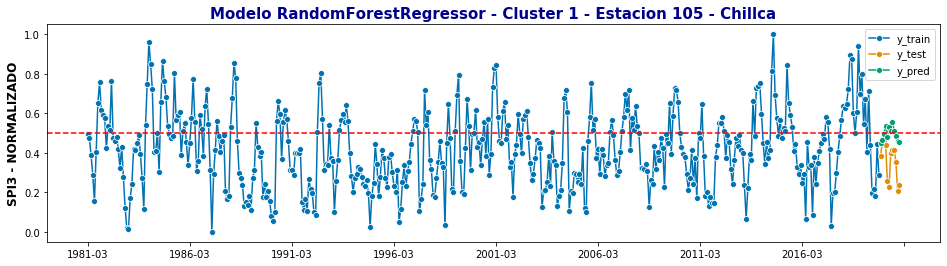

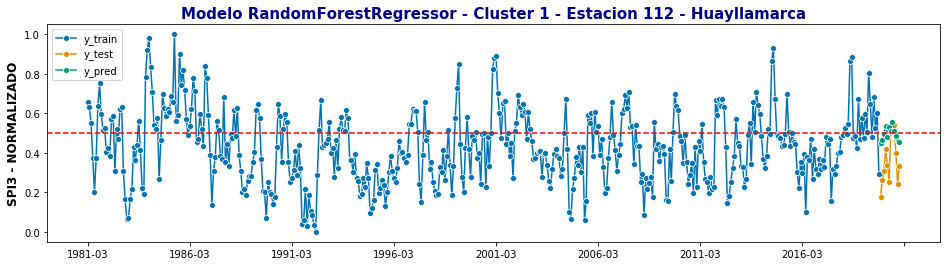

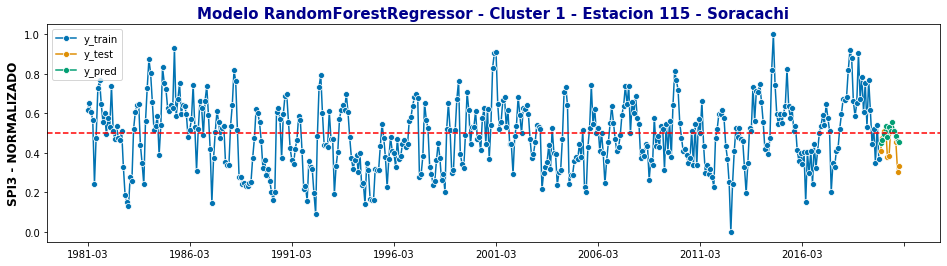

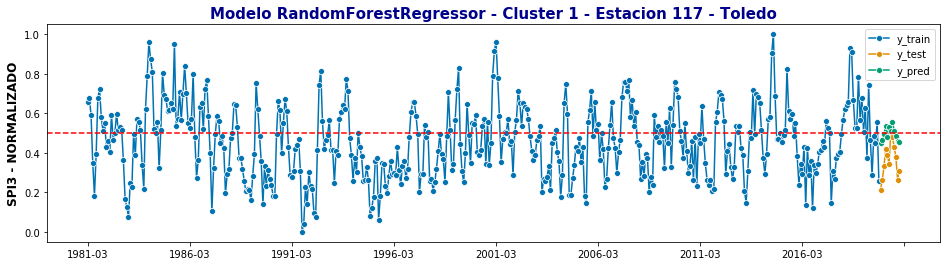

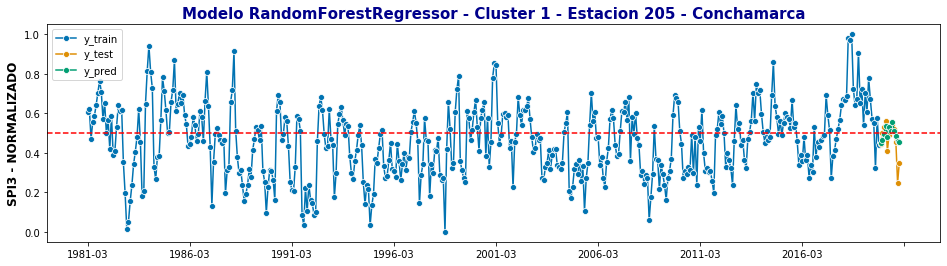

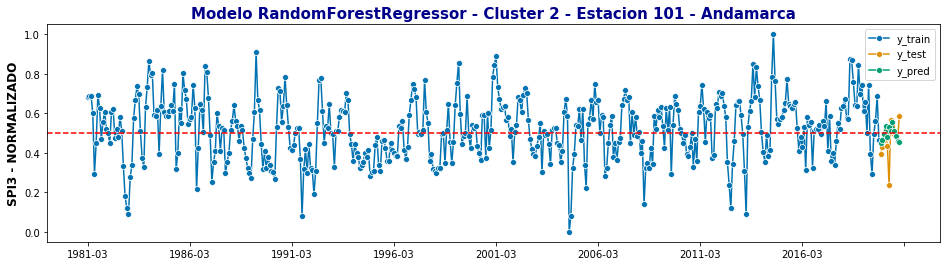

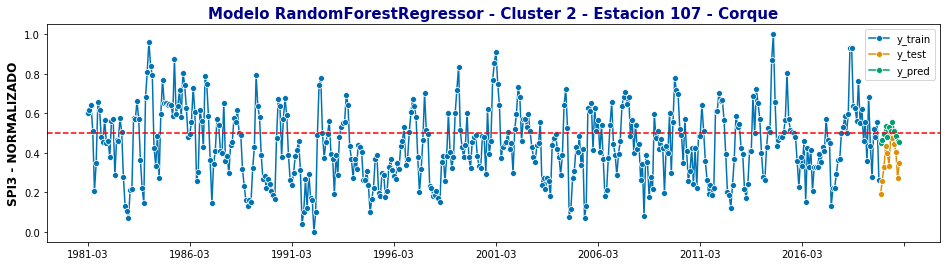

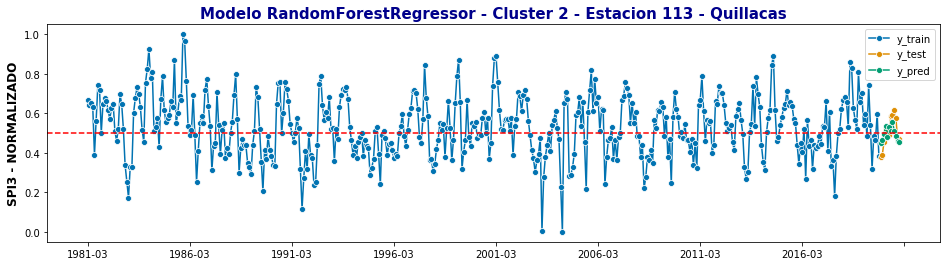

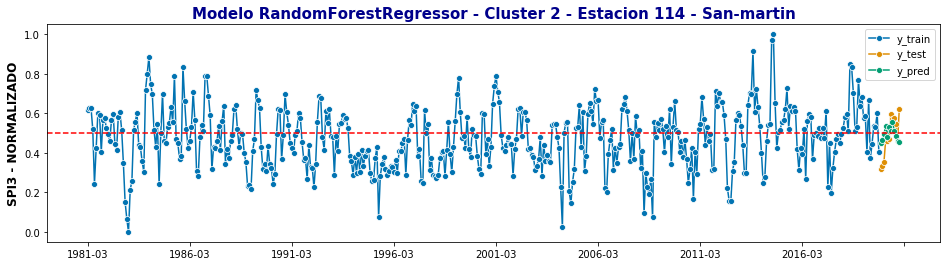

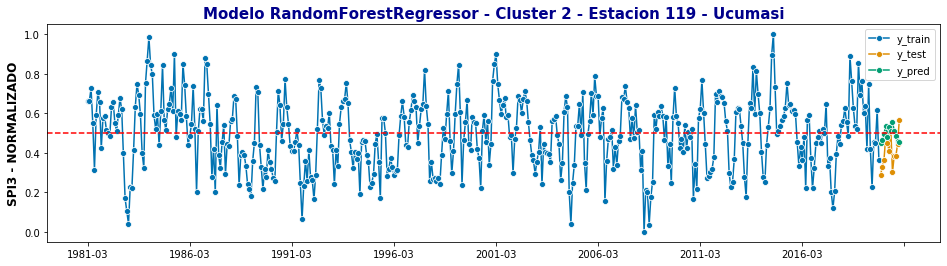

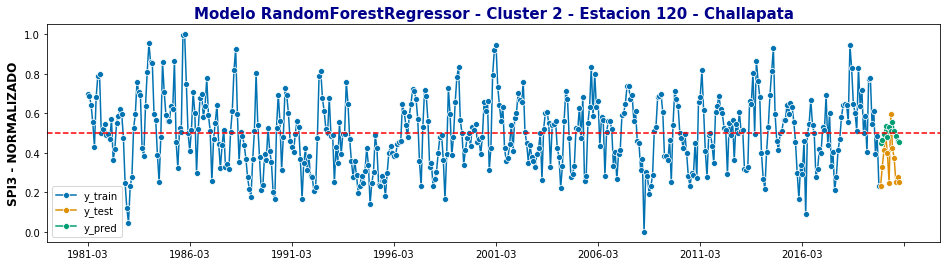

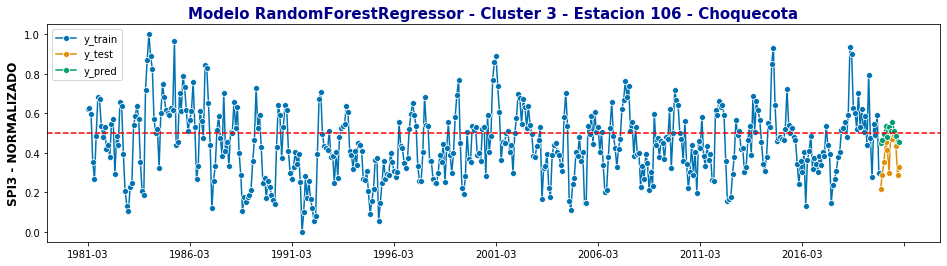

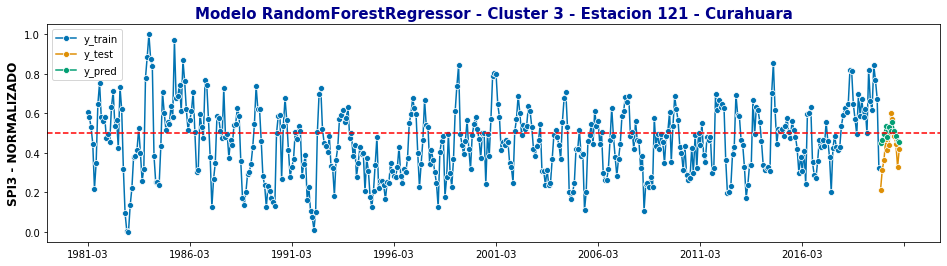

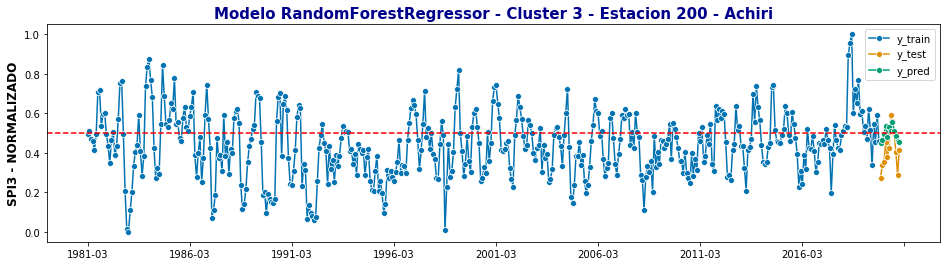

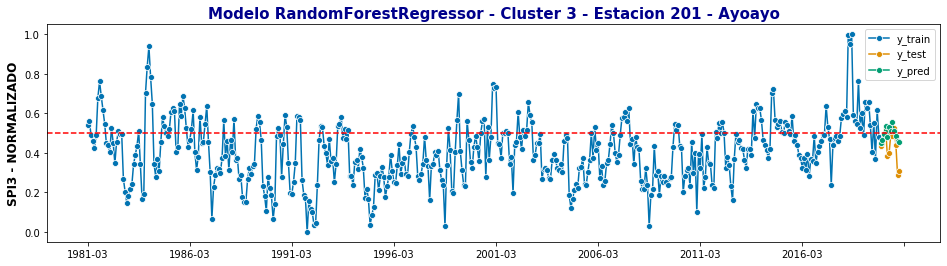

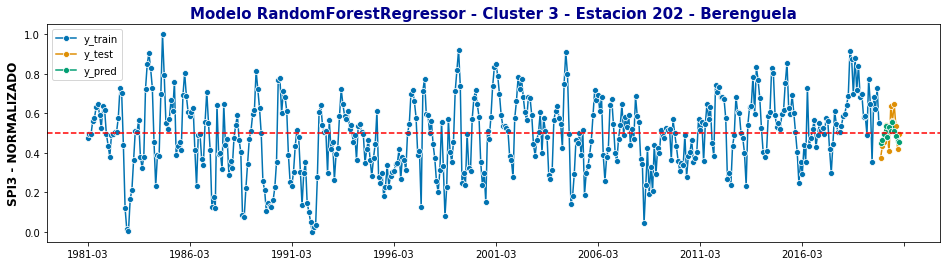

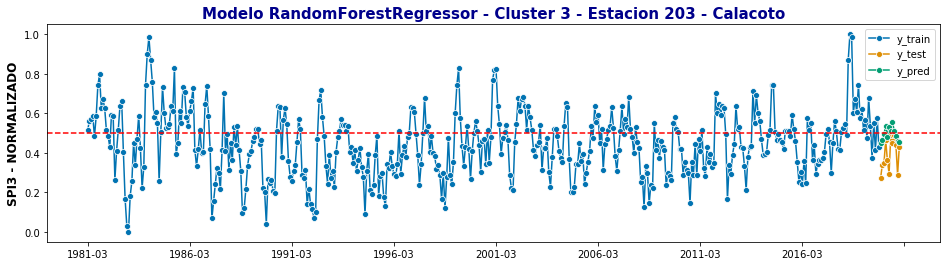

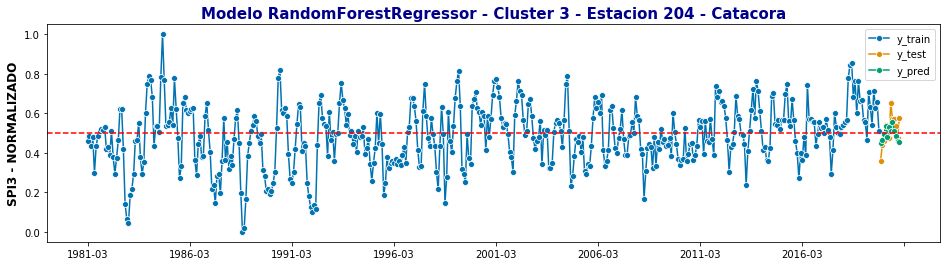

Escala: 12


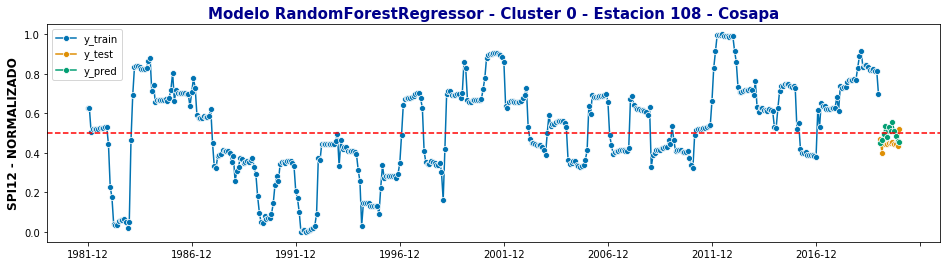

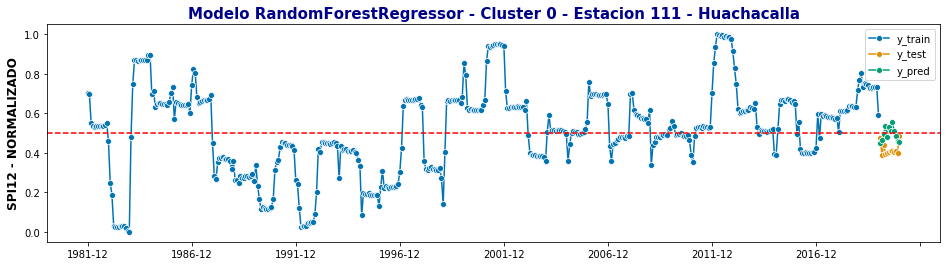

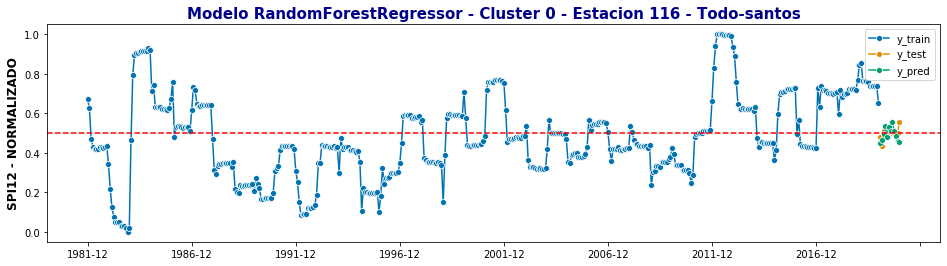

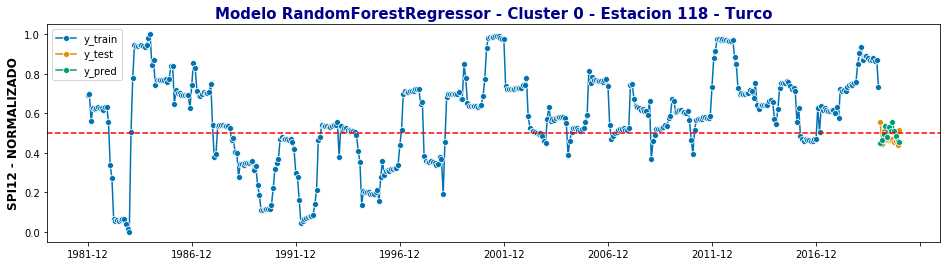

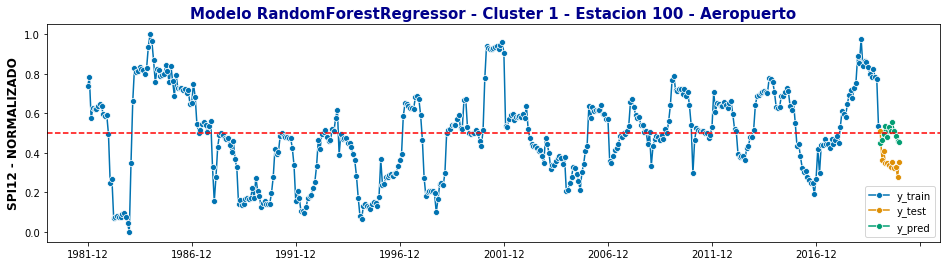

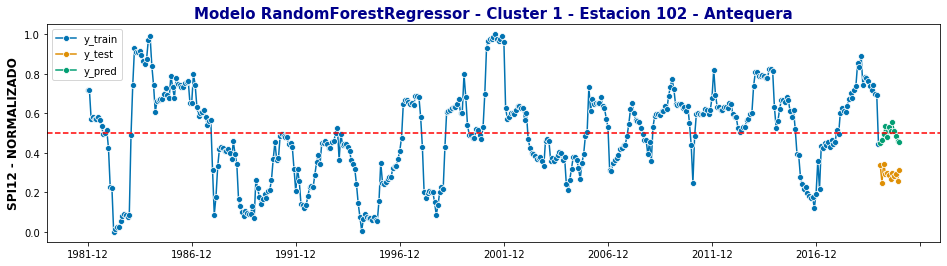

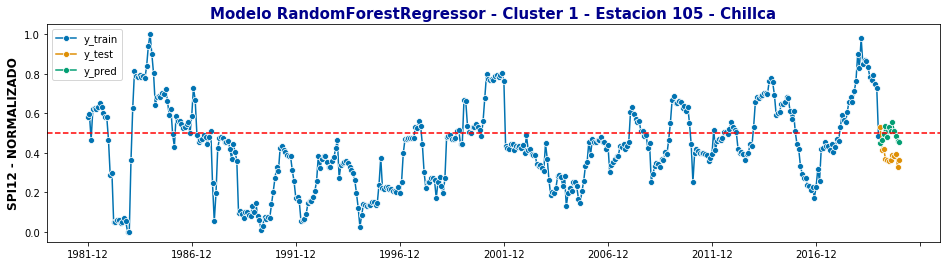

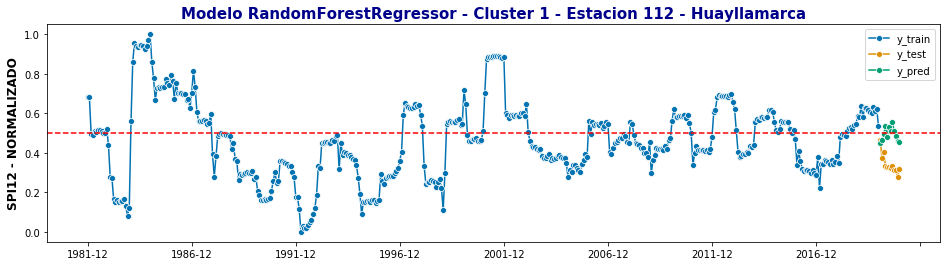

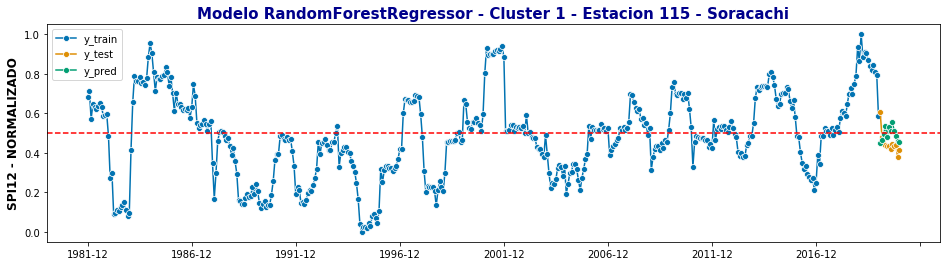

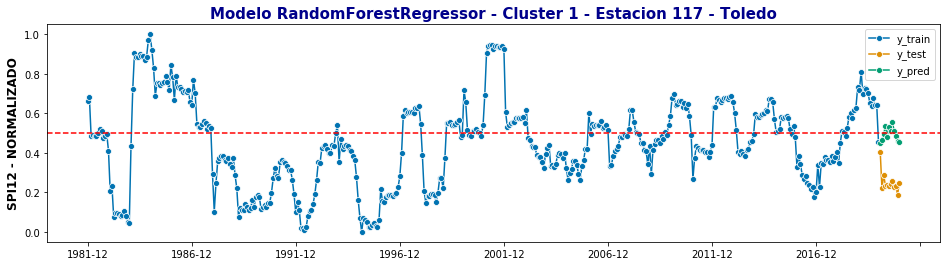

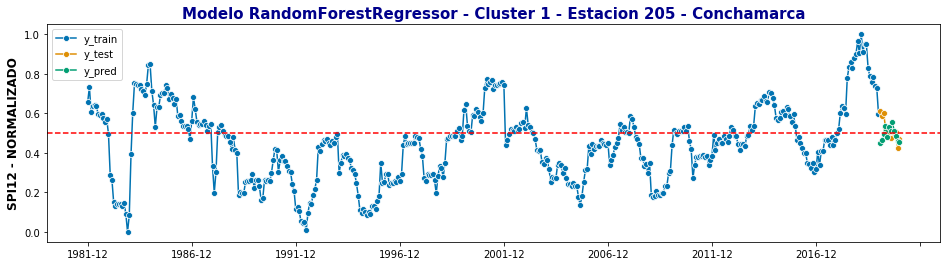

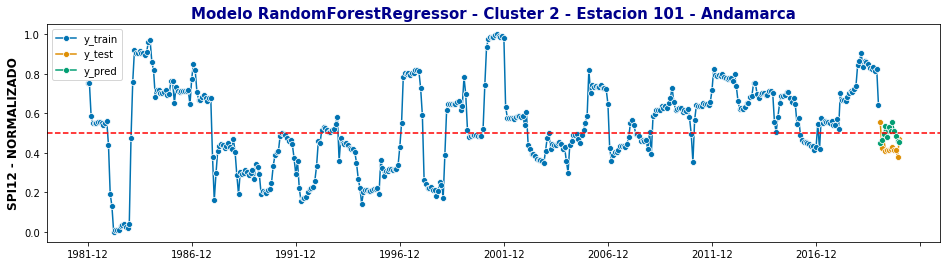

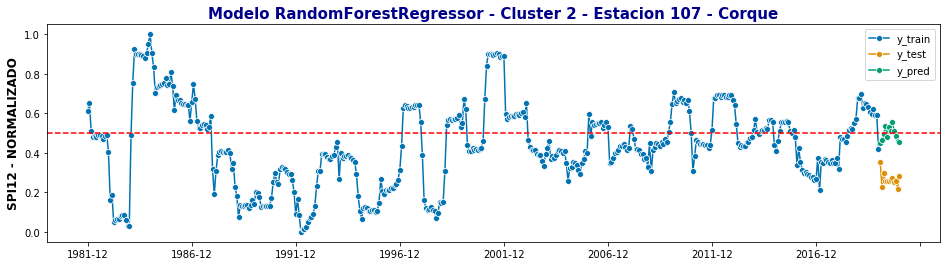

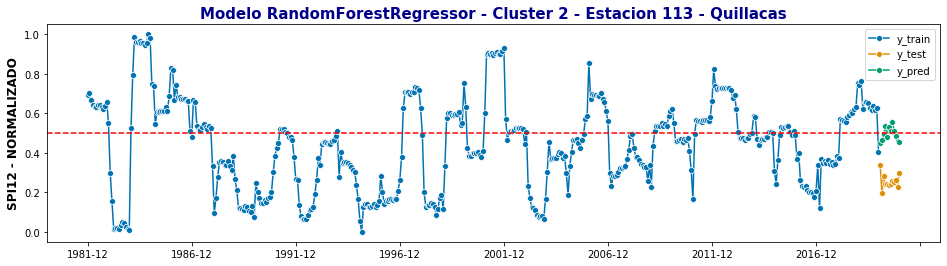

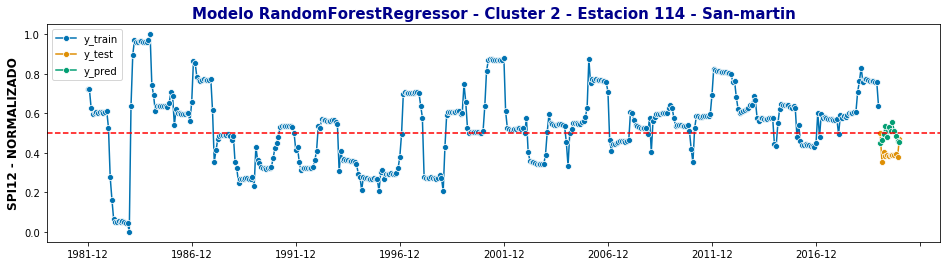

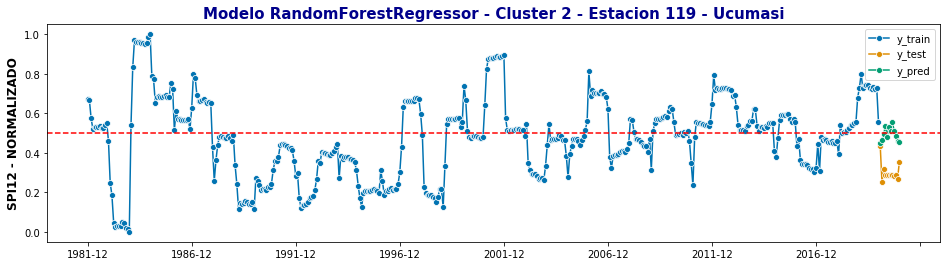

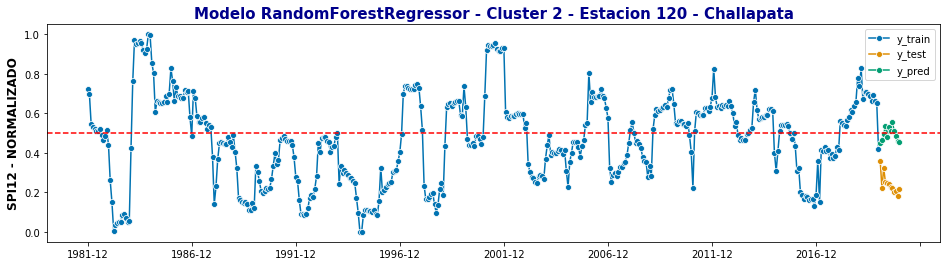

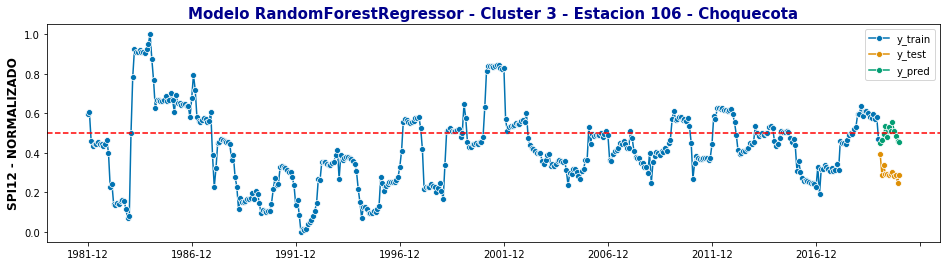

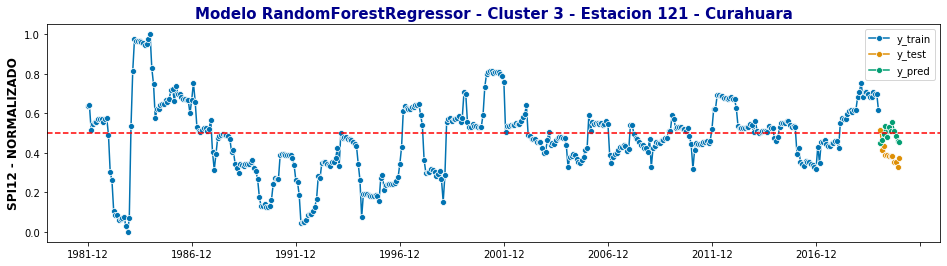

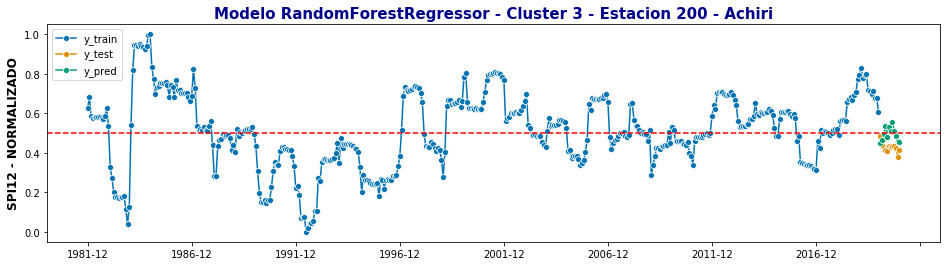

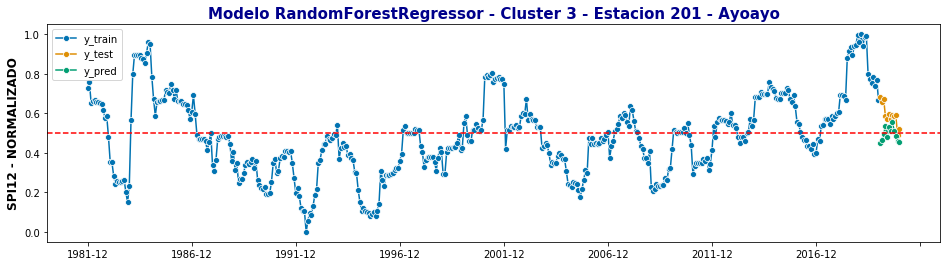

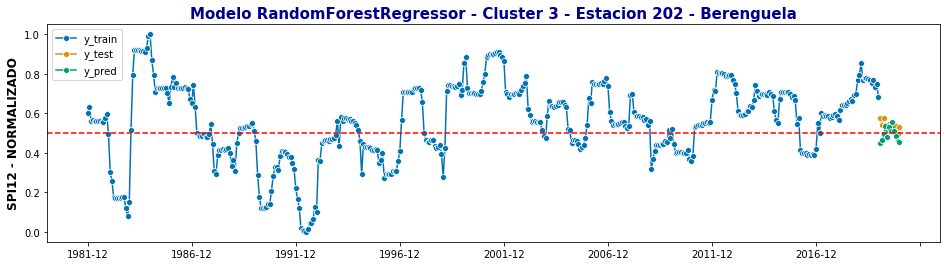

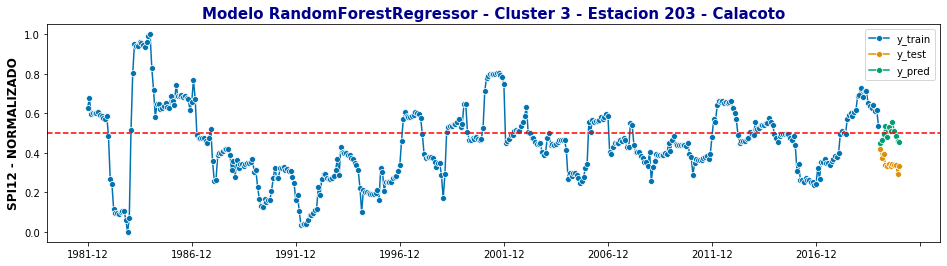

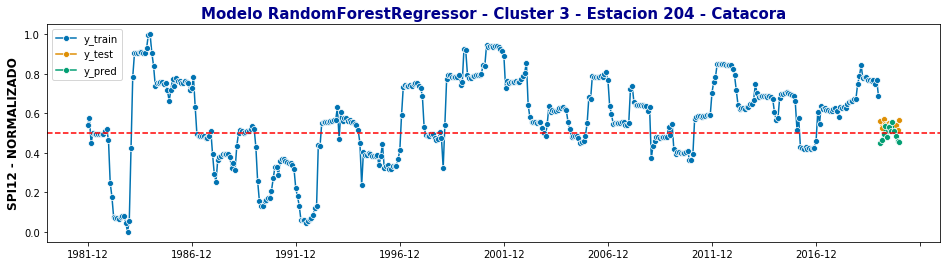

In [25]:
graficar_pred_est(df_pred, 'Modelo RandomForestRegressor')

In [26]:
df_pred

spi3_c0   spi3_c1   spi3_c2   spi3_c3  spi12_c0  spi12_c1  spi12_c2  \
0   0.448396  0.414514  0.369857  0.498000  0.679440  0.572850  0.383265   
1   0.465649  0.406908  0.404210  0.450001  0.673591  0.570371  0.377116   
2   0.494744  0.342724  0.454083  0.482887  0.664839  0.572005  0.397437   
3   0.536609  0.452893  0.471771  0.523268  0.675755  0.589772  0.385425   
4   0.481834  0.359663  0.446699  0.509740  0.669541  0.585273  0.391837   
5   0.531478  0.391690  0.428031  0.535092  0.665265  0.591921  0.393287   
6   0.510524  0.388470  0.439399  0.502114  0.670051  0.574652  0.389366   
7   0.557693  0.414977  0.509031  0.533438  0.677392  0.573926  0.402261   
8   0.511962  0.394635  0.498110  0.540182  0.684058  0.577815  0.407550   
9   0.487554  0.388291  0.462192  0.503252  0.716407  0.569934  0.416334   
10  0.457776  0.404481  0.481569  0.470040  0.711976  0.570747  0.423962   
11  0.455309  0.407108  0.483768  0.426273  0.681542  0.563103  0.439731   

    spi12_c3  
0   0.632293  
1   0.581521  
2   0.588712  
3   0.577232  
4   0.572958  
5   0.576323  
6   0.585452  
7   0.585900  
8   0.577417  
9   0.565931  
10  0.572575  
11  0.588393

In [27]:
df_eval

spi3_c0   spi3_c1   spi3_c2   spi3_c3  spi12_c0  spi12_c1  spi12_c2  \
MAPE  0.149838  0.235680  0.423793  0.109794  0.436582  0.142896  0.719021   
MAE   0.058042  0.104592  0.126047  0.055395  0.204628  0.070351  0.158587   
RMSE  0.077693  0.114207  0.143723  0.077352  0.208529  0.077563  0.169274   
MSE   0.006036  0.013043  0.020656  0.005983  0.043484  0.006016  0.028654   

      spi12_c3  
MAPE  0.069974  
MAE   0.037955  
RMSE  0.041084  
MSE   0.001688

In [28]:
t1 = pd.Timestamp.now()
t1-t0

Timedelta('0 days 02:24:39.787545')